# Problem statement – 
Create a data story of the online/social media response of a movie or a TV series.

# Instructions:
1. Select one recently launched movie or a TV show from Hotstar or Netlifx. 
2. Extract reviews, tweets, or any relevant text data from social media platforms/websites like Twitter, Facebook, Google etc.
3. Clean the data and create an appropriate schema to store it in a table format(s).
4. Perform EDA and apply relevant ML algorithms if required.
5. Highlight insights/relevant stats and conclude whether the movie/TV series has received a positive/negative or neutral response from the online community.
6. Record your outputs as a presentation or a dashboard.
7. Share the following outputs
    
    a. PDF file of your presentation OR a dashboard link to an online public library (Example Tableau public or Power BI gallery).
    
    b. Supporting documents in PDF format – code, data, approach etc. 

## Mapping to ML problem:

1. It is multiclass classification problem with 3 classes: Positive, Neutral, Negative.
2. Data is scrapped from IMDB website using Selenium and BeutifulSoup which contains, review_title, review_text and review_rating in the range 1 to 10.
**Performance matrix (Multiclass):**
    
    a. Multiclass log-loss (Cross entropy)
    b. Precision, Recall, f1_micro, Confusion matrix. 

In [1]:
import pandas as pd #Using panda to create our dataframe
# Import Selenium and its sub libraries
import selenium 
from selenium import webdriver
# Import BS4
import requests #needed to load the page for BS4
from bs4 import BeautifulSoup


In [13]:
PATH = r"C:\Users\Admin\Downloads\chromedriver_win32\chromedriver.exe"

In [14]:
# Reference: https://hungpham89.medium.com/a-beginner-guide-for-scraping-data-from-imdb-for-user-reviews-using-selenium-and-beautifulsoup-c60e89a4ad1a
def get_review():
    '''
    Get the review from input as url for IMDB movies list.
    The function takes 2 input the url of the movies and the name of the folder to store the data
    For each folder, the function will grab the review for each movies and store into respective file.
    '''

    #After the webpage opened, we can extract the title, hyperlink, year of each movies
    #Set initial empty list for each element:

    url = 'https://www.imdb.com/title/tt6468322/'
    #setup user agent for BS4, except some rare case, it would be the same for most browser 
    user_agent = {'User-agent': 'Mozilla/5.0'}
    #Use request.get to load the whole page
    response = requests.get(url, headers = user_agent)
    #Parse the request object to BS4 to transform it into html structure
    soup = BeautifulSoup(response.text, 'html.parser')
    
    #Find the link marked by the USER REVIEWS link text.
    review_link = url+soup.find('a', text = 'User reviews').get('href')
    #print(review_link)
    driver = webdriver.Chrome(PATH)
    driver.get(review_link)
    driver.implicitly_wait(4) # tell the webdriver to wait for 1 seconds for the page to load to prevent blocked by anti spam software


    # Set up action to click on 'load more' button
    # note that each page on imdb has 25 reviews
    page =1 #Set initial variable for while loop
    #We want at least 1000 review, so get 50 at a safe number
    while page<500:
        try:
            #find the load more button on the webpage
            load_more = driver.find_element_by_id('load-more-trigger')
            #click on that button
            load_more.click()
            page+=1 #move on to next loadmore button
            
        except:
            #If couldnt find any button to click, stop
            break
    print(page)
    # After fully expand the page, we will grab data from whole website
    review = driver.find_elements_by_class_name('review-container')
    #Set list for each element:
    title = []
    content = []
    rating = []
    date = []
    user_name = []
    #run for loop to get 
    for n in range(0,5000):
        try:
            #Some reviewers only give review text or rating without the other, 
            #so we use try/except here to make sure each block of content must has all the element before append them to the list

            #Check if each review has all the elements
            ftitle = review[n].find_element_by_class_name('title').text
            #For the review content, some of them are hidden as spoiler, 
            #so we use the attribute 'textContent' here after extracting the 'content' tag
            fcontent = review[n].find_element_by_class_name('content').get_attribute("textContent").strip()
            frating = review[n].find_element_by_class_name('rating-other-user-rating').text
            fdate = review[n].find_element_by_class_name('review-date').text
            fname = review[n].find_element_by_class_name('display-name-link').text


            #Then add them to the respective list
            title.append(ftitle)
            content.append(fcontent)
            rating.append(frating)
            date.append(fdate)
            user_name.append(fname)
        except:
            continue
    #Build data dictionary for dataframe
    data = {'User_name': user_name, 
            'Review title': title, 
            'Review Rating': rating,
            'Review date' : date,
            'Review_body' : content
           }
    #Build dataframe for each movie to export
    print('Scraping Done')
    review = pd.DataFrame(data = data)    
    review['Movie_name'] = 'Money_heist' #create new column with the same movie name column    
    review.to_csv('IMDB_scrapped.csv') #store them into individual file for each movies, so we can combine or check them later
    driver.quit()

In [15]:
get_review()

C:\Users\Admin\AppData\Local\Temp/ipykernel_1128/2557331749.py:23: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(PATH)
C:\Users\Admin\AppData\Local\Temp/ipykernel_1128/2557331749.py:35: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  load_more = driver.find_element_by_id('load-more-trigger')


141


C:\Users\Admin\AppData\Local\Temp/ipykernel_1128/2557331749.py:45: DeprecationWarning: find_elements_by_* commands are deprecated. Please use find_elements() instead
  review = driver.find_elements_by_class_name('review-container')
C:\Users\Admin\anaconda3\lib\site-packages\selenium\webdriver\remote\webelement.py:446: UserWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  warnings.warn("find_element_by_* commands are deprecated. Please use find_element() instead")


Scraping Done


In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os



In [93]:
df= pd.read_csv('IMDB_scrapped.csv')
df.head()


,Unnamed: 0,User_name,Review title,Review Rating,Review date,Review_body,Movie_name
0,0,lee_eisenberg,theft of heft,10/10,24 August 2021,One of the many great series on Netflix depict...,Money_heist
1,1,ma-cortes,Awesome Spanish series with plenty of thrills ...,8/10,24 November 2018,Creator Alex Pina's last one results to be a s...,Money_heist
2,2,searchanddestroy-1,What a mess!!!!,1/10,13 June 2018,I expected far better than this. This Tv serie...,Money_heist
3,3,grantss,"Clever and intriguing, initially, but gets dum...",5/10,9 January 2019,"A band of robbers, lead by a man known simply ...",Money_heist
4,4,deloudelouvain,Watch it in Spanish.,8/10,31 July 2020,All my friends were talking about La Casa De P...,Money_heist


## 1.1 Reading Data

In [94]:
print("Number of data points in train data", df.shape)
print('-'*50)
print("The attributes of data :", df.columns.values)

Number of data points in train data (3466, 7)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'User_name' 'Review title' 'Review Rating' 'Review date'
 'Review_body' 'Movie_name']


In [95]:
for i in df['Review Rating']:
    if type(i)== int:
        continue
    else:
        temp=i.replace('/10','')
        df['Review Rating'].replace({i:int(temp)},inplace=True)
    
df

,Unnamed: 0,User_name,Review title,Review Rating,Review date,Review_body,Movie_name
0,0,lee_eisenberg,theft of heft,10,24 August 2021,One of the many great series on Netflix depict...,Money_heist
1,1,ma-cortes,Awesome Spanish series with plenty of thrills ...,8,24 November 2018,Creator Alex Pina's last one results to be a s...,Money_heist
2,2,searchanddestroy-1,What a mess!!!!,1,13 June 2018,I expected far better than this. This Tv serie...,Money_heist
3,3,grantss,"Clever and intriguing, initially, but gets dum...",5,9 January 2019,"A band of robbers, lead by a man known simply ...",Money_heist
4,4,deloudelouvain,Watch it in Spanish.,8,31 July 2020,All my friends were talking about La Casa De P...,Money_heist
...,...,...,...,...,...,...,...
3461,3461,mobilelunchbox,idea is good but messed up characters with man...,4,22 February 2019,The idea is good but messed up characters with...,Money_heist
3462,3462,DARK10x,Shame,1,5 September 2021,Some of the creators and actors supporting chi...,Money_heist
3463,3463,mudassiruabdullahi,The movie sweet die! (Another way of saying th...,10,5 April 2020,How i wish there is morethan 10stars for me to...,Money_heist
3464,3464,tanveersunny,Just awesome,10,5 September 2019,One of the best TV shows I've watched so far. ...,Money_heist


In [96]:
df['Review Rating'].describe()

count    3466.000000
mean        6.641373
std         3.434366
min         1.000000
25%         3.000000
50%         8.000000
75%        10.000000
max        10.000000
Name: Review Rating, dtype: float64

In [97]:
print("Distribution of Review Ratings: \n", df['Review Rating'].value_counts(ascending=True))

Distribution of Review Ratings: 
 2      157
4      165
3      184
6      186
5      198
7      215
8      247
9      374
1      540
10    1200
Name: Review Rating, dtype: int64


### Most of the user given ratings are 8, 9, 1 and 10. Top i.e. 10 ratings are given by 1200 users.

## Univariate Analysis

## Using PDF


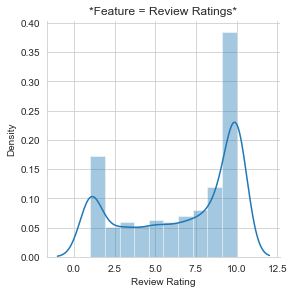

In [84]:
sns.set_style("whitegrid")
g=sns.FacetGrid(df, size=4)
g=g.map(sns.distplot, 'Review Rating').add_legend().set(title='*Feature = Review Ratings*')
plt.show()

# Lets look at some text reviews to understand polarity of reviews:

In [151]:
# Lets print one random review text to check its polarity.
t=df[['Review_body']].loc[df['Review Rating']==3]
print(t['Review_body'][67])

I tuned into this hoping for a decent and clever bank heist tale. In some parts I got this.It feels like they first of all gave the script to some intelligent writers who conceived of these brilliant schemes to get into the bank, deal with the police and plan their escape. The kinds of antics that make the audience think 'wow, these guys are pretty smart'. The stakes are big, the planning is meticulous and the huge rewards worthy of the effort.When that was done, they then gave the script to a bunch of horny, adolescent teenagers who must have previously written 80's Australian soap operas. It is terrible. From establishing the actual job, it descends into a series of foolish characters who literally cannot keep their hands off each other and cannot keep their head in the game. They're shagging in vaults and toilets and offices. They're shagging when they are casing the joint, when they are doing the job and even with the lead investigator.From a job offering untold riches and the comm

In [141]:
Negative_rating= df[['Review_body']].loc[df['Review Rating']<4]
Negative_rating.shape

(881, 1)

### If we see the above review, we can easily guess that this review is totally negative. So the reviews with rating 3 and less will be considered as the negative review for this analysis task. There are 881 Negative reviews.

In [153]:
t=df[['Review_body']].loc[df['Review Rating']==4]
print(t['Review_body'][44])

It has some good and unexpected moments, but also lots of thin plot points. It's written in the usual millennial style: lengthen the thing again and again. And again.But the worst aspect is watching the characters having relationships and often taking the dumbest possible decisions. I would like to say they are totally unrealistic, but it's worse, it's like watching the Big Brother on tv: a bunch of crazy, narcissistic and brainless guys, fu**ing, fighting and switching sides all the time.Tokyo, Rio and Angel are extremely unlikeable, Nairobi and Denver almost are. Some of them are very badly acted. On the other hand, Berlin and Moscow are interesting and well acted characters. The Professor is just, well, the Professor.
                
                    42 out of 67 found this helpful.
                        
                            Was this review helpful?  Sign in to vote.
                        
                        
                    Permalink


In [157]:
t=df[['Review_body']].loc[df['Review Rating']==7]
print(t['Review_body'][46])

I give 6.5 but rounded up. First off you need to get past the ridiculous plot that seeks to garner sympathy for criminals. Has the obligatory Netflix PC sub-plots and a few very annoying characters. But still very well produced and even enjoyable despite gaping holes in the story and absolutely unbelievable action sequences. Guns being pulled and pointed at each other constantly is definitely eye rolling material. Acting is above average and dialogue rings true. Some real depth of emotion in the characters emerge. Seasons 1& 2 are far superior to 3 & 4.
                
                    1 out of 5 found this helpful.
                        
                            Was this review helpful?  Sign in to vote.
                        
                        
                    Permalink


In [142]:
Neutral_rating= df[['Review_body']].loc[((df['Review Rating']>=4)&(df['Review Rating']<8))]
Neutral_rating.shape

(764, 1)

### If we see the above reviews, There are some positive as well as negative aspects are mentioned. So the reviews with rating between 4 and 7 will be considered as the Neutral review for this analysis task. There are 764 Neutral reviews.

In [163]:
t=df[['Review_body']].loc[df['Review Rating']==8]
print(t['Review_body'][3315])

Leaving out the fact that this, is one of the greatest things Spain ever made (after some horror films), I must say that I wasn't fully satisfied about some logics during the episodes. "El Professor" obviously was the most intelligent character of the series, but some dynamics they were left to chance. Fortunatly, everything ended up to his advantage, but I hoped that nothing was by chance, like I said. Apart from that, the final left me a little bit down, like many others because during the episodes they made me fond of the characters for leaving me with too many questions. Anyway, I really enjoyed it and hope it's not the last season!
                
                    4 out of 8 found this helpful.
                        
                            Was this review helpful?  Sign in to vote.
                        
                        
                    Permalink


In [143]:
Positive_rating= df[['Review_body']].loc[df['Review Rating']>=8]
Positive_rating.shape

(1821, 1)

### If we see the above review, we can easily guess that this review is totally Positive. So the reviews with rating 8 and above will be considered as the Positive review for this analysis task. There are 1821 Positive reviews.

# Preprocessing of text data:

1) If we see Review_title also has some information about the sentiments of the user. Also it describes whole review few words. Hence we will use this feature also.

2) For this analysis we are going to use three features from datframe which are Review_title, Review_body and Review_rating 

In [165]:
data= df[['Review title','Review_body','Review Rating']]
data

,Review title,Review_body,Review Rating
0,theft of heft,One of the many great series on Netflix depict...,10
1,Awesome Spanish series with plenty of thrills ...,Creator Alex Pina's last one results to be a s...,8
2,What a mess!!!!,I expected far better than this. This Tv serie...,1
3,"Clever and intriguing, initially, but gets dum...","A band of robbers, lead by a man known simply ...",5
4,Watch it in Spanish.,All my friends were talking about La Casa De P...,8
...,...,...,...
3461,idea is good but messed up characters with man...,The idea is good but messed up characters with...,4
3462,Shame,Some of the creators and actors supporting chi...,1
3463,The movie sweet die! (Another way of saying th...,How i wish there is morethan 10stars for me to...,10
3464,Just awesome,One of the best TV shows I've watched so far. ...,10


In [167]:
data['Review title']

0                                           theft of heft
1       Awesome Spanish series with plenty of thrills ...
2                                         What a mess!!!!
3       Clever and intriguing, initially, but gets dum...
4                                    Watch it in Spanish.
                              ...                        
3461    idea is good but messed up characters with man...
3462                                                Shame
3463    The movie sweet die! (Another way of saying th...
3464                                         Just awesome
3465                       Difficult task for the writers
Name: Review title, Length: 3466, dtype: object

In [200]:
# There are some special characters, stop words, brackets in Review title texts.
#Lets preprocess it
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not' as they contribute in Negative reviews
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

 
from tqdm import tqdm
def preprocess_text(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentance in tqdm(text_data):
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        sent = re.sub(r"<.*>","",sent, flags=re.MULTILINE)
        sent = re.sub(r"[\n\t\-\\\/]"," ",sent, flags=re.MULTILINE)
        sent = re.sub(r"\b_([a-zA-z]+)_\b",r"\1",sent)  # to replace _word_ to word
        sent = re.sub(r"\b_([a-zA-z]+)\b",r"\1",sent)   # to replace_word to word
        sent = re.sub(r"\b([a-zA-z]+)_\b",r"\1",sent)   # to replace word_ to word
        sent = re.sub(r'\b\w{1,2}\b'," ",sent) #remove words <2
        sent = re.sub(r"\b\w{15,}\b"," ",sent) #remove words >15
        sent = re.sub(r'\d',"",sent, flags=re.MULTILINE)
        
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text



### Preprocessing: Review title

In [201]:
preprocessed_review_title = preprocess_text(data['Review title'].values)
preprocessed_review_title

100%|██████████| 3466/3466 [00:00<00:00, 14453.60it/s]


['theft heft',
 'awesome spanish series plenty thrills action twists turns',
 'mess',
 'clever intriguing initially gets dumber dumber longer goes',
 'watch spanish',
 'casa papel',
 'good enough',
 'not forget breathe',
 'unique unique',
 'life',
 'lady detective talks mummy going gets tough',
 'slickly sexy spanish steal',
 'season',
 'one best series ever seen',
 'every season gets even better',
 'not used',
 'raquel worst cop ever',
 'great',
 'quite intersting',
 'wonderful show',
 'end',
 'absorbing paper series',
 'parts bad parts good',
 'masterpiece',
 'intriguing different',
 'clunker capital',
 'would like say loved heist show tremendously went tad long',
 'really bad soap opera worse school production not even laughable',
 'awaiting final',
 'honestly',
 'superb',
 'casa papel',
 'every little thing drama drawn expanded',
 'good overrated',
 'started pretty good',
 'pretty entertaining',
 'awesome start gets somewhat boring toward season',
 'money',
 'ridiculous',
 'show tu

### Preprocessing: Review body

In [229]:
# There are some special characters, stop words, brackets in Review title texts.
#Lets preprocess it
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not' as they contribute in Negative reviews
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't",'found','review','helpful','sign','vote','permlink']

 
from tqdm import tqdm
def preprocess_text(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentance in tqdm(text_data):
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        sent = re.sub(r"<.*>","",sent, flags=re.MULTILINE)
        sent = re.sub(r"[\n\t\-\\\/]"," ",sent, flags=re.MULTILINE)
        sent = re.sub(r"\b_([a-zA-z]+)_\b",r"\1",sent)  # to replace _word_ to word
        sent = re.sub(r"\b_([a-zA-z]+)\b",r"\1",sent)   # to replace_word to word
        sent = re.sub(r"\b([a-zA-z]+)_\b",r"\1",sent)   # to replace word_ to word
        sent = re.sub(r'\b\w{1,2}\b'," ",sent) #remove words <2
        sent = re.sub(r"\b\w{15,}\b"," ",sent) #remove words >15
        sent = re.sub(r'\d',"",sent, flags=re.MULTILINE)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text



In [230]:
print(data['Review_body'][2])
print(data['Review_body'][12])
print(data['Review_body'][67])

I expected fr better thn this. This Tv series is fr too long, too much "ft", useless moments nd chrcters, the plying is wful, unbelievble t the most, nd this TV show is not brutl, not bloody enough for this kind of subject, of scheme. The producers intended to involve the lrgest udiences possible. Home udiences, the whole fmily. This brought cheesy situtions, for sissies. NOT FOR ME. But I dmit tht there re good story lines, in the bsic scheme, I men, nd interesting situtions. But the whole is jeoprdized by this non sense destined, I repet, for the lrgest udiences possible.
                
                    210 out of 542 found this helpful.
                        
                            Ws this review helpful?  Sign in to vote.
                        
                        
                    Permlink
I gve seson one nd two of this show  much deserved 10/10 but I'm t  loss to understnd why they mde seson 3?Seson 3 is the ntithesis of the former sesons. It ruins the mostly

In [231]:
preprocessed_review_body = preprocess_text(data['Review_body'].values)
print(preprocessed_review_body[2])
print(preprocessed_review_body[12])
print(preprocessed_review_body[67])

100%|██████████| 3466/3466 [00:01<00:00, 2016.79it/s]

expected better thn series long much useless moments chrcters plying wful unbelievble show not brutl not bloody enough kind subject scheme producers intended involve lrgest udiences possible home udiences whole fmily brought cheesy situtions sissies not dmit tht good story lines bsic scheme men interesting situtions whole jeoprdized non sense destined repet lrgest udiences possible
gve seson one two show much deserved loss understnd mde seson seson ntithesis former sesons ruins mostly light herted vibe tht estblished replcing something much drker worse still simply mny respects bltnt hsh wht went like str wrs feels like mking something ske mking hppy hve first two sesons leving seson
tuned hoping decent clever bnk heist tle prts got feels like first gve script intelligent writers conceived brillint schemes get bnk del police pln escpe kinds ntics tht mke udience think wow guys pretty smrt stkes big plnning meticulous huge rewrds worthy effort tht done gve script bunch horny dolescent t

In [237]:
pos=[8,9,10]
neut=[4,5,6,7]
neg=[1,2,3]
preprocessed_ratings=[]
for i in data['Review Rating']:
    if i in neg:
        preprocessed_ratings.append(0)       # Assigning 0 for negative reviews
    elif i in neut:
        preprocessed_ratings.append(1)       # Assigning 1 for neutral reviews
    elif i in pos:
        preprocessed_ratings.append(2)       # Assigning 2 for positive reviews


In [238]:
print(len(preprocessed_review_title))
print(len(preprocessed_review_body))
print(len(preprocessed_ratings))

3466
3466
3466


In [239]:
final_data= pd.DataFrame()
final_data['review_title']= preprocessed_review_title
final_data['review_text']= preprocessed_review_body
final_data['class']= preprocessed_ratings
final_data

,review_title,review_text,class
0,theft heft,one mny gret series netflix depicts group peop...,2
1,awesome spanish series plenty thrills action t...,cretor alex pin lst one results splendid serie...,2
2,mess,expected better thn series long much useless m...,0
3,clever intriguing initially gets dumber dumber...,bnd robbers led known simply nothe professor i...,1
4,watch spanish,friends tlking bout ppel relly not get hve cll...,2
...,...,...,...
3461,idea good messed characters many points unconv...,ide good messed chrcters mny points unconvinci...,1
3462,shame,cretors ctors supporting child killers zionist...,0
3463,movie sweet die another way saying movie super...,wish morethn strs rte movie definitely time best,2
3464,awesome,one best shows wtched excellent work,2


In [242]:
final_data.to_csv('preprocessed_data.csv')   # storing it to csv file for further use

# Loading Data

In [217]:
data  = pd.read_csv('preprocessed_data.csv')

In [218]:
data.head()

,Unnamed: 0,review_title,review_text,class
0,0,theft heft,one mny gret series netflix depicts group peop...,2
1,1,awesome spanish series plenty thrills action t...,cretor alex pin lst one results splendid serie...,2
2,2,mess,expected better thn series long much useless m...,0
3,3,clever intriguing initially gets dumber dumber...,bnd robbers led known simply nothe professor i...,1
4,4,watch spanish,friends tlking bout ppel relly not get hve cll...,2


In [219]:
# replacing nan values with name of the series
data['review_title'] = data['review_title'].replace(np.nan, 'money heist') 
data['review_text'] = data['review_text'].replace(np.nan, 'money heist') 

# Train Test split

In [220]:
y = data['class'].values
X = data.drop(columns=['class','Unnamed: 0'], axis=1)

print('Orinial data point shape: ', X.shape)
print('Orinial class label shape: ', y.shape)

#Splitting the data into train and test.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)

print('Training data shape: ',X_train.shape)
print('Training class label shape: ',y_train.shape)
print('Test data shape: ',X_test.shape)
print('Test class label shape: ',y_test.shape)

Orinial data point shape:  (3466, 2)
Orinial class label shape:  (3466,)
Training data shape:  (2772, 2)
Training class label shape:  (2772,)
Test data shape:  (694, 2)
Test class label shape:  (694,)


# Make Data Model Ready: encoding review_title

# TF-IDF vectorization of review_title

In [221]:
vectorizertfidf = TfidfVectorizer(min_df=1,ngram_range=(1,4), max_features=5000)    # limiting the no. of features =5000
vectorizertfidf.fit(X_train['review_title'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_title_tfidf = vectorizertfidf.transform(X_train['review_title'].values)
X_test_title_tfidf = vectorizertfidf.transform(X_test['review_title'].values)

print(X_train_title_tfidf.shape, y_train.shape)
print(X_test_title_tfidf.shape, y_test.shape)
print("="*100)

(2772, 5000) (2772,)
(694, 5000) (694,)


# TFIDF_W2V vectorization of review_title

In [222]:
# we are converting a dictionary with word as a key, and the idf as a value
title_dictionary = dict(zip(vectorizertfidf.get_feature_names(), list(vectorizertfidf.idf_)))
tfidf_title_words = set(vectorizertfidf.get_feature_names())

In [223]:
#to load glove vectors 
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [224]:
# average Word2Vec
# compute average word2vec for each review.
def tfidfw2v(data,glove_words,tfidf_words,model,dictionary):
    """This function transforms sentences into tfidf weighted vectors and returns dataset of such vectors"""
    tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sentence in tqdm(data['review_title'].values): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        tf_idf_weight =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if (word in glove_words) and (word in tfidf_words):
                vec = model[word] # getting the vector for each word
                # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
                tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
                vector += (vec * tf_idf) # calculating tfidf weighted w2v
                tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        tfidf_w2v_vectors.append(vector)
    return tfidf_w2v_vectors

X_train_title_tfidf_w2v = tfidfw2v(X_train,glove_words,tfidf_title_words,model,title_dictionary)
X_test_title_tfidf_w2v = tfidfw2v(X_test,glove_words,tfidf_title_words,model,title_dictionary)


100%|██████████| 694/694 [00:00<00:00, 17220.79it/s]


In [225]:
print(len(X_train_title_tfidf_w2v))
print(len(X_train_title_tfidf_w2v[0]))
print(len(X_test_title_tfidf_w2v))
print(len(X_test_title_tfidf_w2v[0]))

2772
300
694
300


# Make Data Model Ready: encoding review_text

# TF-IDF vectorization of review_text

In [226]:
vectorizertfidf_t = TfidfVectorizer(min_df=1,ngram_range=(1,4), max_features=5000)    # limiting the no. of features =5000
vectorizertfidf_t.fit(X_train['review_text'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_text_tfidf = vectorizertfidf_t.transform(X_train['review_text'].values)
X_test_text_tfidf = vectorizertfidf_t.transform(X_test['review_text'].values)

print(X_train_text_tfidf.shape, y_train.shape)
print(X_test_text_tfidf.shape, y_test.shape)
print("="*100)

(2772, 5000) (2772,)
(694, 5000) (694,)


# TFIDF_W2V vectorization of review_text

In [227]:
# we are converting a dictionary with word as a key, and the idf as a value
text_dictionary = dict(zip(vectorizertfidf_t.get_feature_names(), list(vectorizertfidf_t.idf_)))
tfidf_text_words = set(vectorizertfidf_t.get_feature_names())

In [228]:
# average Word2Vec
# compute average word2vec for each review.
def tfidfw2v(data,glove_words,tfidf_words,model,dictionary):
    """This function transforms sentences into tfidf weighted vectors and returns dataset of such vectors"""
    tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sentence in tqdm(data['review_text'].values): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        tf_idf_weight =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if (word in glove_words) and (word in tfidf_words):
                vec = model[word] # getting the vector for each word
                # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
                tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
                vector += (vec * tf_idf) # calculating tfidf weighted w2v
                tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        tfidf_w2v_vectors.append(vector)
    return tfidf_w2v_vectors

X_train_text_tfidf_w2v = tfidfw2v(X_train,glove_words,tfidf_text_words,model,text_dictionary)
X_test_text_tfidf_w2v = tfidfw2v(X_test,glove_words,tfidf_text_words,model,text_dictionary)


100%|██████████| 694/694 [00:00<00:00, 2061.56it/s]


In [229]:
print(len(X_train_text_tfidf_w2v))
print(len(X_train_text_tfidf_w2v[0]))
print(len(X_test_text_tfidf_w2v))
print(len(X_test_text_tfidf_w2v[0]))

2772
300
694
300


# Sentiment scores

In [230]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
def sentiment_score(data):
    """This function returns vector containing lists of sentiment scores for each sentence or essay"""
    sentiment = SentimentIntensityAnalyzer()
    sentiment_score_vector=[]
    for i in tqdm(data['review_text'].values):
        ss= sentiment.polarity_scores(i)
        sentiment_score_vector.append(list(ss.values()))
    return np.array(sentiment_score_vector)
        
X_train_sentiment_scores= sentiment_score(X_train)
X_test_sentiment_scores= sentiment_score(X_test)

100%|██████████| 694/694 [00:00<00:00, 1117.22it/s]


## Concatinating all the features for Set1  (Tfidf)

In [249]:
from scipy.sparse import hstack
X_tr1 = hstack((X_train_title_tfidf,X_train_text_tfidf,X_train_sentiment_scores)).tocsr()
X_te1 = hstack((X_test_title_tfidf,X_test_text_tfidf,X_test_sentiment_scores)).tocsr()

print("Final Data matrix")
print(X_tr1.shape, y_train.shape)
print(X_te1.shape, y_test.shape)
print("="*100)

Final Data matrix
(2772, 10004) (2772,)
(694, 10004) (694,)


## Concatinating all the features for Set2 (Tfidf_w2v)

In [250]:
X_train_title_tfidf_w2v=np.array(X_train_title_tfidf_w2v)
X_train_text_tfidf_w2v=np.array(X_train_text_tfidf_w2v)
X_test_title_tfidf_w2v=np.array(X_test_title_tfidf_w2v)
X_test_text_tfidf_w2v=np.array(X_test_text_tfidf_w2v)

In [251]:
from scipy.sparse import hstack
X_tr2 = np.hstack((X_train_title_tfidf_w2v,X_train_text_tfidf_w2v,X_train_sentiment_scores))
X_te2 = np.hstack((X_test_title_tfidf_w2v,X_test_text_tfidf_w2v,X_test_sentiment_scores))

print("Final Data matrix")
print(X_tr2.shape, y_train.shape)
print(X_te2.shape, y_test.shape)
print("="*100)

Final Data matrix
(2772, 604) (2772,)
(694, 604) (694,)


In [283]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    
    labels = [0,1,2]
    cmap=sns.light_palette("green")
    # representing A in heatmap format
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # representing B in heatmap format
    print("-"*50, "Recall matrix"    , "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in precision matrix",A.sum(axis=1))

# Model: SVC

### Hyper-parameter tuning for set(1)

In [290]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

parameters={'kernel':['linear', 'rbf', 'poly'], "C":[0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]}

svc = SVC()
clf = GridSearchCV(svc, parameters, cv=3, scoring='f1_micro',return_train_score=True)
clf.fit(X_tr1, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)

In [291]:
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,1.305284,0.034144,0.552319,0.007755,0.00001,linear,"{'C': 1e-05, 'kernel': 'linear'}",0.525974,0.524892,0.524892,0.525253,0.000510,26,0.524892,0.525433,0.525433,0.525253,0.000255
1,1.383597,0.006500,0.562466,0.055603,0.00001,rbf,"{'C': 1e-05, 'kernel': 'rbf'}",0.525974,0.524892,0.524892,0.525253,0.000510,26,0.524892,0.525433,0.525433,0.525253,0.000255
2,1.258972,0.034911,0.505180,0.007360,0.00001,poly,"{'C': 1e-05, 'kernel': 'poly'}",0.525974,0.524892,0.524892,0.525253,0.000510,26,0.524892,0.525433,0.525433,0.525253,0.000255
3,1.508692,0.190902,0.534776,0.008744,0.0005,linear,"{'C': 0.0005, 'kernel': 'linear'}",0.525974,0.524892,0.524892,0.525253,0.000510,26,0.524892,0.525433,0.525433,0.525253,0.000255
4,1.399395,0.021565,0.531211,0.012757,0.0005,rbf,"{'C': 0.0005, 'kernel': 'rbf'}",0.525974,0.524892,0.524892,0.525253,0.000510,26,0.524892,0.525433,0.525433,0.525253,0.000255
5,1.394253,0.108157,0.559531,0.040051,0.0005,poly,"{'C': 0.0005, 'kernel': 'poly'}",0.525974,0.524892,0.524892,0.525253,0.000510,26,0.524892,0.525433,0.525433,0.525253,0.000255
6,1.317616,0.019486,0.555806,0.024576,0.0001,linear,"{'C': 0.0001, 'kernel': 'linear'}",0.525974,0.524892,0.524892,0.525253,0.000510,26,0.524892,0.525433,0.525433,0.525253,0.000255
7,1.347863,0.030814,0.520796,0.007367,0.0001,rbf,"{'C': 0.0001, 'kernel': 'rbf'}",0.525974,0.524892,0.524892,0.525253,0.000510,26,0.524892,0.525433,0.525433,0.525253,0.000255
8,1.371551,0.149929,0.536416,0.019497,0.0001,poly,"{'C': 0.0001, 'kernel': 'poly'}",0.525974,0.524892,0.524892,0.525253,0.000510,26,0.524892,0.525433,0.525433,0.525253,0.000255
9,1.392621,0.015638,0.541629,0.014729,0.005,linear,"{'C': 0.005, 'kernel': 'linear'}",0.525974,0.527056,0.527056,0.526696,0.000510,25,0.524892,0.527056,0.528680,0.526876,0.001552


In [292]:
clf.best_params_

{'C': 0.5, 'kernel': 'linear'}

## Training SVC with best hyperparameter on set1(tfidf)

For values of best C =  0.5 The train log loss is: 0.39057823563031446
For values of best alpha =  0.5 The test log loss is: 0.6785022202840479
Number of misclassified points  27.37752161383285
-------------------------------------------------- Confusion matrix --------------------------------------------------


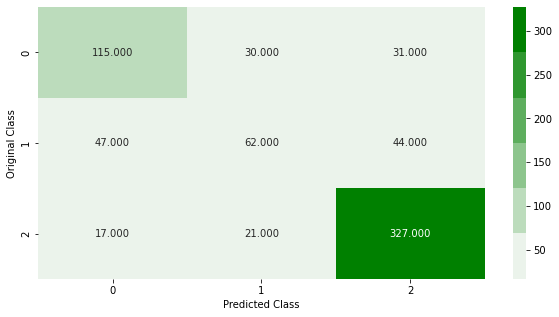

-------------------------------------------------- Precision matrix --------------------------------------------------


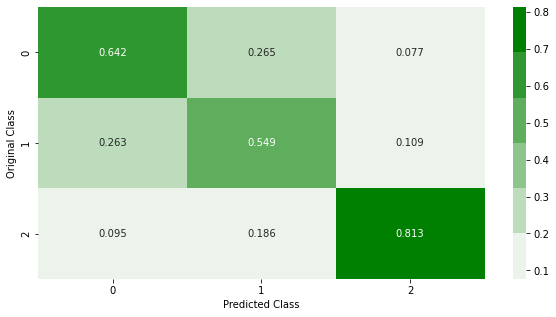

Sum of columns in precision matrix [1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


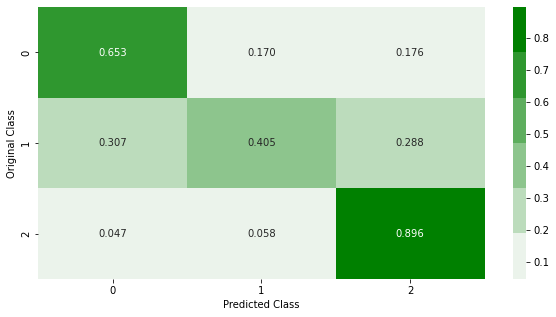

Sum of rows in precision matrix [1. 1. 1.]


In [293]:
from sklearn.metrics import log_loss
from sklearn.calibration import CalibratedClassifierCV

svc_classifier = SVC(kernel='linear', C=0.5, probability=True)
svc_classifier.fit(X_tr1,y_train)
sig_clf = CalibratedClassifierCV(svc_classifier, method="sigmoid")
sig_clf.fit(X_tr1,y_train)

predict_y = sig_clf.predict_proba(X_tr1)
print ('For values of best C = ', 0.5, "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_te1)
print('For values of best alpha = ', 0.5, "The test log loss is:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, sig_clf.predict(X_te1))

31


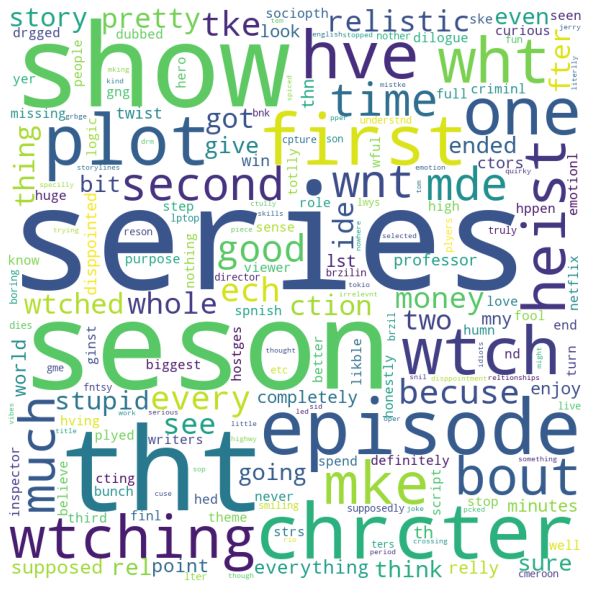

In [310]:
#Finding False Positive data points from set1 predicted by classifier
test_pred_class=sig_clf.predict(X_te1)     
false_positive_set1 = X_test[(y_test == 0) & (test_pred_class == 2)] #False Positives data points from set1
print(len(false_positive_set1))
# Refrence:https://www.geeksforgeeks.org/generating-word-cloud-python/
from wordcloud import WordCloud, STOPWORDS

comment_words = ''
stopwords = set(STOPWORDS)
# iterate through the csv file
for sentence in false_positive_set1.review_text:
     
    # typecaste each val to string
    sentence = str(sentence)
 
    # split the value
    tokens = sentence.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()


### Hyper-parameter tuning for set(2) tfidf_w2v

In [294]:
parameters={'kernel':['linear', 'rbf', 'poly'], "C":[0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]}

svc1 = SVC()
clf1 = GridSearchCV(svc1, parameters, cv=3, scoring='f1_micro',return_train_score=True)
clf1.fit(X_tr2, y_train)

results1 = pd.DataFrame.from_dict(clf1.cv_results_)

In [295]:
results1

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,1.823937,0.042931,0.593594,0.003326,0.00001,linear,"{'C': 1e-05, 'kernel': 'linear'}",0.525974,0.524892,0.524892,0.525253,0.000510,28,0.524892,0.525433,0.525433,0.525253,0.000255
1,1.788164,0.036604,0.912292,0.003750,0.00001,rbf,"{'C': 1e-05, 'kernel': 'rbf'}",0.525974,0.524892,0.524892,0.525253,0.000510,28,0.524892,0.525433,0.525433,0.525253,0.000255
2,1.717373,0.117195,0.602786,0.006631,0.00001,poly,"{'C': 1e-05, 'kernel': 'poly'}",0.525974,0.524892,0.524892,0.525253,0.000510,28,0.524892,0.525433,0.525433,0.525253,0.000255
3,1.838872,0.029913,0.595417,0.023801,0.0005,linear,"{'C': 0.0005, 'kernel': 'linear'}",0.525974,0.524892,0.524892,0.525253,0.000510,28,0.524892,0.525433,0.525974,0.525433,0.000442
4,2.002857,0.150973,0.910638,0.020912,0.0005,rbf,"{'C': 0.0005, 'kernel': 'rbf'}",0.525974,0.524892,0.524892,0.525253,0.000510,28,0.524892,0.525433,0.525433,0.525253,0.000255
5,1.882087,0.068112,0.641821,0.049515,0.0005,poly,"{'C': 0.0005, 'kernel': 'poly'}",0.525974,0.524892,0.524892,0.525253,0.000510,28,0.524892,0.525433,0.525433,0.525253,0.000255
6,1.918733,0.111464,0.634010,0.030461,0.0001,linear,"{'C': 0.0001, 'kernel': 'linear'}",0.525974,0.524892,0.524892,0.525253,0.000510,28,0.524892,0.525433,0.525433,0.525253,0.000255
7,1.854559,0.004097,0.949966,0.050191,0.0001,rbf,"{'C': 0.0001, 'kernel': 'rbf'}",0.525974,0.524892,0.524892,0.525253,0.000510,28,0.524892,0.525433,0.525433,0.525253,0.000255
8,1.710706,0.020348,0.598713,0.003855,0.0001,poly,"{'C': 0.0001, 'kernel': 'poly'}",0.525974,0.524892,0.524892,0.525253,0.000510,28,0.524892,0.525433,0.525433,0.525253,0.000255
9,1.651761,0.129509,0.579580,0.041559,0.005,linear,"{'C': 0.005, 'kernel': 'linear'}",0.677489,0.674242,0.663420,0.671717,0.006015,18,0.684524,0.697511,0.698593,0.693543,0.006393


In [296]:
clf1.best_params_

{'C': 1, 'kernel': 'rbf'}

## Training SVC with best hyperparameter on set2(tfidf_w2v)

For values of best C =  1 The train log loss is: 0.627643942289785
For values of best alpha =  1 The test log loss is: 0.7669805351784179
Number of misclassified points  28.530259365994237
-------------------------------------------------- Confusion matrix --------------------------------------------------


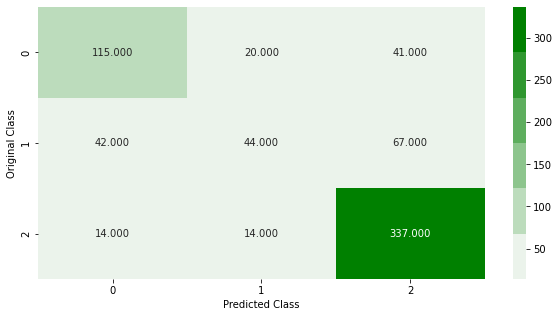

-------------------------------------------------- Precision matrix --------------------------------------------------


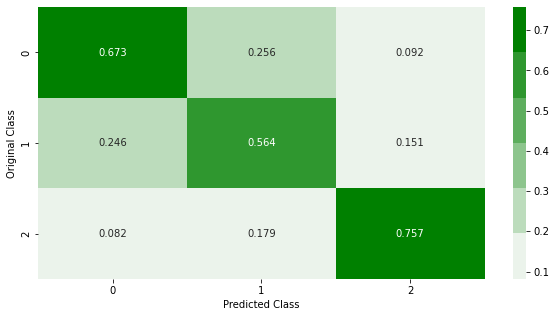

Sum of columns in precision matrix [1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


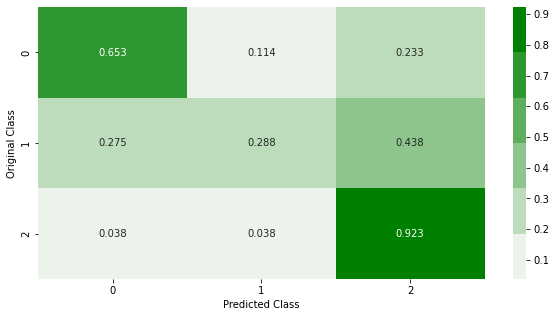

Sum of rows in precision matrix [1. 1. 1.]


In [297]:
svc_classifier1 = SVC(kernel='rbf', C=1, probability=True)
svc_classifier1.fit(X_tr2,y_train)
sig_clf1 = CalibratedClassifierCV(svc_classifier1, method="sigmoid")
sig_clf1.fit(X_tr2,y_train)

predict_y = sig_clf1.predict_proba(X_tr2)
print ('For values of best C = ', 1, "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf1.predict_proba(X_te2)
print('For values of best alpha = ', 1, "The test log loss is:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, sig_clf1.predict(X_te2))

41


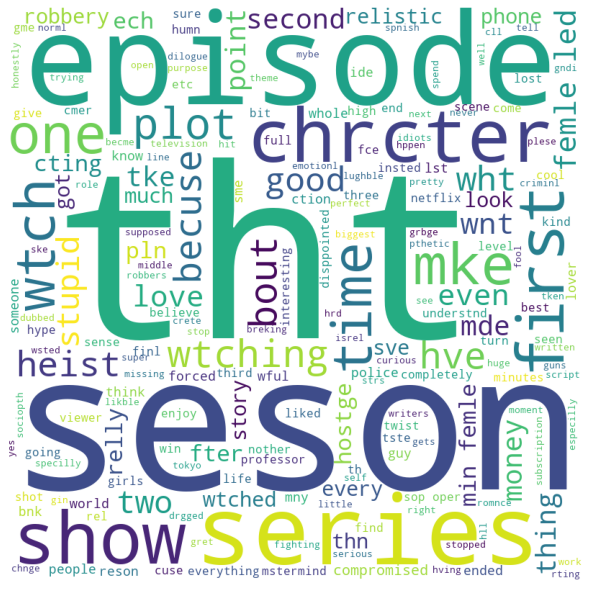

In [311]:
#Finding False Positive data points from set1 predicted by classifier
test_pred_class=sig_clf1.predict(X_te2)     
false_positive_set2 = X_test[(y_test == 0) & (test_pred_class == 2)] #False Positives data points from set1
print(len(false_positive_set2))
# Refrence:https://www.geeksforgeeks.org/generating-word-cloud-python/
from wordcloud import WordCloud, STOPWORDS

comment_words = ''
stopwords = set(STOPWORDS)
# iterate through the csv file
for sentence in false_positive_set2.review_text:
     
    # typecaste each val to string
    sentence = str(sentence)
 
    # split the value
    tokens = sentence.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()


# Model: XGBoost

### Hyper-parameter tuning for set(1) tfidf

In [301]:
from xgboost import XGBClassifier
parameters={'n_estimators':[10,50,75,100,150,200,500]}
xgb = XGBClassifier(verbosity = 0)
clf_xgb = GridSearchCV(xgb, parameters, cv=3, scoring='f1_micro',return_train_score=True)
clf_xgb.fit(X_tr1, y_train)
results_xgb = pd.DataFrame.from_dict(clf_xgb.cv_results_)

In [302]:
results_xgb

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.889373,0.013192,0.015628,3.251596e-06,10,{'n_estimators': 10},0.650433,0.646104,0.664502,0.653680,0.007854,7,0.860390,0.853355,0.865801,0.859848,0.005095
1,4.108439,0.244990,0.015624,7.786718e-07,50,{'n_estimators': 50},0.674242,0.678571,0.703463,0.685426,0.012876,5,0.974567,0.976732,0.971861,0.974387,0.001992
2,5.845825,0.263038,0.026040,7.366089e-03,75,{'n_estimators': 75},0.669913,0.682900,0.704545,0.685786,0.014285,4,0.991342,0.991883,0.988636,0.990620,0.001420
3,7.576608,0.114832,0.026039,1.472976e-02,100,{'n_estimators': 100},0.681818,0.686147,0.700216,0.689394,0.007854,1,0.994048,0.996753,0.994048,0.994949,0.001275
4,10.781366,0.169114,0.026033,7.374800e-03,150,{'n_estimators': 150},0.677489,0.681818,0.705628,0.688312,0.012371,3,0.997294,0.998918,0.998377,0.998196,0.000675
5,13.654287,0.154731,0.036441,7.375080e-03,200,{'n_estimators': 200},0.676407,0.683983,0.705628,0.688672,0.012382,2,0.998377,0.998918,0.998377,0.998557,0.000255
6,27.461275,0.108095,0.052072,7.367671e-03,500,{'n_estimators': 500},0.670996,0.681818,0.694805,0.682540,0.009734,6,0.998918,0.998918,0.998377,0.998737,0.000255


In [303]:
clf_xgb.best_params_

{'n_estimators': 100}

## Training XGBoost with best hyperparameter on set1(tfidf)

For values of best n_estimators =  100 The train log loss is: 0.27435792495111994
For values of best n_estimators =  100 The test log loss is: 0.7017454137819261
Number of misclassified points  30.25936599423631
-------------------------------------------------- Confusion matrix --------------------------------------------------


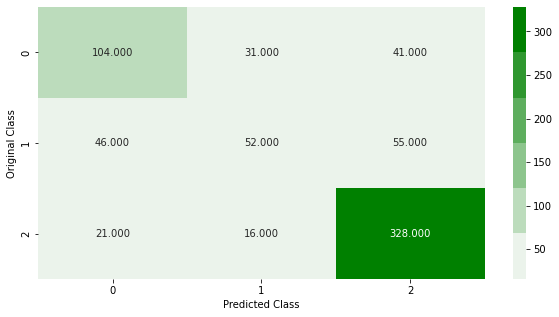

-------------------------------------------------- Precision matrix --------------------------------------------------


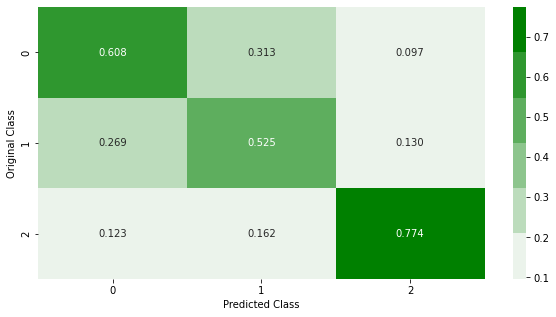

Sum of columns in precision matrix [1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


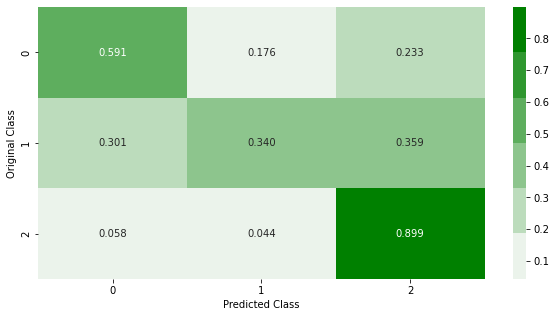

Sum of rows in precision matrix [1. 1. 1.]


In [304]:
xgb = XGBClassifier(n_estimators=100,max_depth=10,learning_rate=0.15,colsample_bytree=0.3,subsample=1,nthread=-1)
xgb.fit(X_tr1,y_train,verbose=True)
sig_clf_xgb = CalibratedClassifierCV(xgb, method="sigmoid")
sig_clf_xgb.fit(X_tr1, y_train)

predict_y = sig_clf_xgb.predict_proba(X_tr1)
print ('For values of best n_estimators = ', 100, "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf_xgb.predict_proba(X_te1)
print('For values of best n_estimators = ', 100, "The test log loss is:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, sig_clf_xgb.predict(X_te1))

41


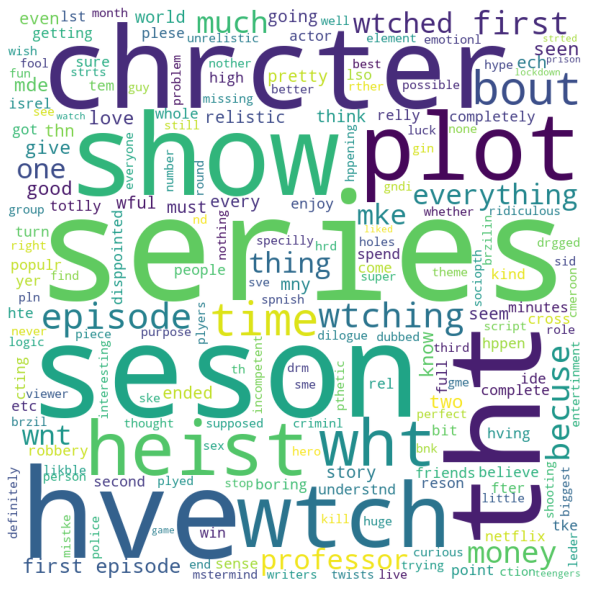

In [312]:
#Finding False Positive data points from set1 predicted by classifier
test_pred_class=sig_clf_xgb.predict(X_te1)     
false_positive_set3 = X_test[(y_test == 0) & (test_pred_class == 2)] #False Positives data points from set1
print(len(false_positive_set3))
# Refrence:https://www.geeksforgeeks.org/generating-word-cloud-python/
from wordcloud import WordCloud, STOPWORDS

comment_words = ''
stopwords = set(STOPWORDS)
# iterate through the csv file
for sentence in false_positive_set3.review_text:
     
    # typecaste each val to string
    sentence = str(sentence)
 
    # split the value
    tokens = sentence.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()


### Hyper-parameter tuning for set(2) tfidf_w2v

In [305]:
from xgboost import XGBClassifier
parameters={'n_estimators':[10,50,75,100,150,200,500]}
xgb1 = XGBClassifier(verbosity = 0)
clf_xgb1 = GridSearchCV(xgb1, parameters, cv=3, scoring='f1_micro',return_train_score=True)
clf_xgb1.fit(X_tr2, y_train)
results_xgb1 = pd.DataFrame.from_dict(clf_xgb1.cv_results_)

In [306]:
results_xgb1

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,4.990696,0.243611,0.018141,0.004221,10,{'n_estimators': 10},0.680736,0.683983,0.669913,0.678211,0.006015,7,0.996753,0.994589,0.992965,0.994769,0.001552
1,21.360879,0.755387,0.031498,0.000353,50,{'n_estimators': 50},0.699134,0.691558,0.695887,0.695527,0.003103,6,0.999459,0.999459,0.999459,0.999459,0.000000
2,27.530501,1.120856,0.020831,0.007365,75,{'n_estimators': 75},0.706710,0.694805,0.704545,0.702020,0.005178,5,0.999459,0.999459,0.999459,0.999459,0.000000
3,32.594416,0.783527,0.023524,0.006377,100,{'n_estimators': 100},0.709957,0.698052,0.708874,0.705628,0.005375,4,0.999459,0.999459,0.999459,0.999459,0.000000
4,41.362499,0.345969,0.020279,0.003482,150,{'n_estimators': 150},0.718615,0.702381,0.704545,0.708514,0.007197,2,0.999459,0.999459,0.999459,0.999459,0.000000
5,46.451995,0.488373,0.020823,0.007369,200,{'n_estimators': 200},0.713203,0.702381,0.707792,0.707792,0.004418,3,0.999459,0.999459,0.999459,0.999459,0.000000
6,70.839119,2.226038,0.034051,0.003988,500,{'n_estimators': 500},0.717532,0.709957,0.704545,0.710678,0.005326,1,0.999459,0.999459,0.999459,0.999459,0.000000


In [307]:
clf_xgb1.best_params_

{'n_estimators': 500}

## Training XGBoost with best hyperparameter on set2(tfidf_w2v)

For values of best n_estimators =  100 The train log loss is: 0.26908783225845484
For values of best n_estimators =  100 The test log loss is: 0.7183752970524304
Number of misclassified points  28.530259365994237
-------------------------------------------------- Confusion matrix --------------------------------------------------


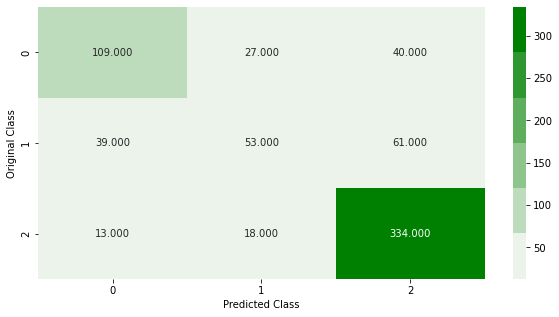

-------------------------------------------------- Precision matrix --------------------------------------------------


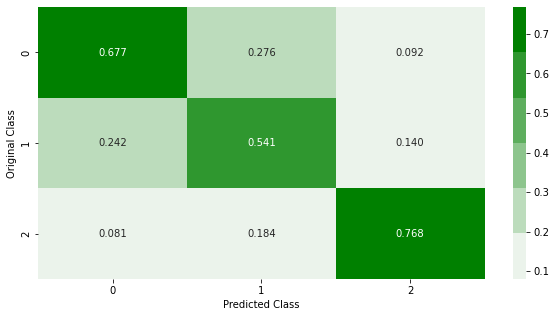

Sum of columns in precision matrix [1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


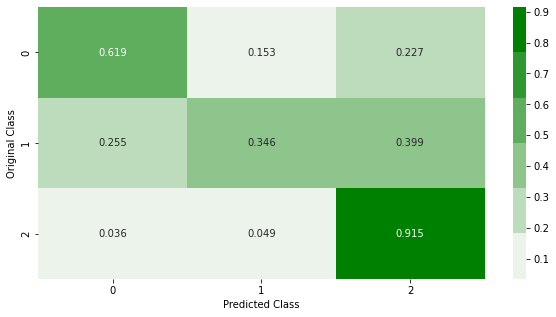

Sum of rows in precision matrix [1. 1. 1.]


In [308]:
xgb1 = XGBClassifier(n_estimators=500,max_depth=10,learning_rate=0.15,colsample_bytree=0.3,subsample=1,nthread=-1)
xgb1.fit(X_tr2,y_train,verbose=True)
sig_clf_xgb1 = CalibratedClassifierCV(xgb1, method="sigmoid")
sig_clf_xgb1.fit(X_tr2, y_train)

predict_y = sig_clf_xgb1.predict_proba(X_tr2)
print ('For values of best n_estimators = ', 100, "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf_xgb1.predict_proba(X_te2)
print('For values of best n_estimators = ', 100, "The test log loss is:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, sig_clf_xgb1.predict(X_te2))

40


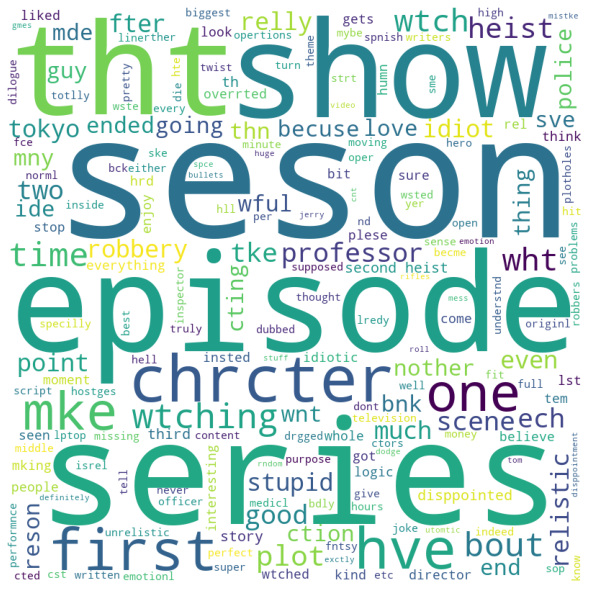

In [313]:
#Finding False Positive data points from set1 predicted by classifier
test_pred_class=sig_clf_xgb1.predict(X_te2)     
false_positive_set4 = X_test[(y_test == 0) & (test_pred_class == 2)] #False Positives data points from set1
print(len(false_positive_set4))
# Refrence:https://www.geeksforgeeks.org/generating-word-cloud-python/
from wordcloud import WordCloud, STOPWORDS

comment_words = ''
stopwords = set(STOPWORDS)
# iterate through the csv file
for sentence in false_positive_set4.review_text:
     
    # typecaste each val to string
    sentence = str(sentence)
 
    # split the value
    tokens = sentence.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()


In [314]:
#Reference: https://www.geeksforgeeks.org/creating-tables-with-prettytable-library-python/
from prettytable import PrettyTable
t = PrettyTable(['Vectorizer', 'Model','train log loss','test log loss'])
t.add_row(['Tfidf', 'SVC',0.3905,0.6785])
t.add_row(['Tfidf_w2v', 'SVC',0.6276,0.7669])
t.add_row(['Tfidf', 'XGBoost',0.2743,0.7017])
t.add_row(['Tfidf_w2v', 'XGBoost',0.2690,0.7183])
print(t)

+------------+---------+----------------+---------------+
| Vectorizer |  Model  | train log loss | test log loss |
+------------+---------+----------------+---------------+
|   Tfidf    |   SVC   |     0.3905     |     0.6785    |
| Tfidf_w2v  |   SVC   |     0.6276     |     0.7669    |
|   Tfidf    | XGBoost |     0.2743     |     0.7017    |
| Tfidf_w2v  | XGBoost |     0.269      |     0.7183    |
+------------+---------+----------------+---------------+


# Conclusion:


1. On the acquired data vectorization using tfidf and SVC with linear kernel gives less test log loss. Also number of misclassified points are also less.

2. The words like 'series', 'chrctr', 'seson', 'show' etc have high importance as shown in the World Cloud.

3. Even though some words in the text don't have particular meaning, they are contributing in defining the class.